In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os, json, random, cv2
import matplotlib.pyplot as plt


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For CUDA deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# Dataset & Transform
class PairedTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
        ])

    def __call__(self, image, mask):
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        image = self.transforms(image)

        random.seed(seed)
        torch.manual_seed(seed)
        mask = self.transforms(mask)
        return image, mask

def json_to_mask(mask_json, image_size):
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)
    for shape in mask_json['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
    return mask

class CrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') and os.path.exists(os.path.join(root_dir, f.replace('.jpg', '.json')))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        json_path = img_path.replace('.jpg', '.json')

        image = Image.open(img_path).convert("RGB")
        with open(json_path, 'r') as f:
            mask_json = json.load(f)
        mask = json_to_mask(mask_json, image.size)
        mask = Image.fromarray(mask)

        if self.transform:
            image, mask = self.transform(image, mask)

        return transforms.ToTensor()(image), transforms.ToTensor()(mask)


# ------------------- Mini Transformer Block -------------------
class MiniTransformerBlock(nn.Module):
    def __init__(self, in_channels, heads=4):  # 1 head for efficiency
        super().__init__()
        self.norm = nn.LayerNorm(in_channels)
        self.attn = nn.MultiheadAttention(embed_dim=in_channels, num_heads=heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(in_channels, in_channels),
            nn.GELU(),
            nn.Linear(in_channels, in_channels)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x_flat = x.flatten(2).transpose(1, 2)  # [B, HW, C]
        x_flat = self.norm(x_flat)
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        x_flat = x_flat + attn_out
        x_flat = x_flat + self.ffn(x_flat)
        x_out = x_flat.transpose(1, 2).reshape(B, C, H, W)
        return x_out



# ------------------- FPN Encoder ----------------------
class FPNEncoder(nn.Module):
    def __init__(self, backbone_name="resnet50", pretrained=True):  # Use ResNet18
        super().__init__()
        resnet = getattr(models, backbone_name)(pretrained=pretrained)
        self.enc0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # 64, /2
        self.enc1 = nn.Sequential(resnet.maxpool, resnet.layer1)          # 64, /4
        self.enc2 = resnet.layer2                                         # 128, /8
        self.enc3 = resnet.layer3                                         # 256, /16
        self.enc4 = resnet.layer4                                         # 512, /32

    def forward(self, x):
        x0 = self.enc0(x)   # 64, /2
        x1 = self.enc1(x0)  # 64, /4
        x2 = self.enc2(x1)  # 128, /8
        x3 = self.enc3(x2)  # 256, /16
        x4 = self.enc4(x3)  # 512, /32
        return [x0, x1, x2, x3, x4]

# ------------------- Decoder with Transformer (Only Deepest 2 Scales) -------------
class FPNTransformerDecoderLite(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Only use transformer at x3 (256) and x2 (128)
        self.transformers = nn.ModuleList([
            MiniTransformerBlock(channels[3], heads=4),  # For x3 (256)
            MiniTransformerBlock(channels[2], heads=4),  # For x2 (128)
        ])
        self.laterals = nn.ModuleList([
            nn.Conv2d(channels[4], channels[3], 1),  # 512->256
            nn.Conv2d(channels[3], channels[2], 1),  # 256->128
            nn.Conv2d(channels[2], channels[1], 1),  # 128->64
            nn.Conv2d(channels[1], channels[0], 1),  # 64->64
        ])
        self.smooths = nn.ModuleList([
            nn.Conv2d(channels[3], channels[3], 3, padding=1),  # 256
            nn.Conv2d(channels[2], channels[2], 3, padding=1),  # 128
            nn.Conv2d(channels[1], channels[1], 3, padding=1),  # 64
            nn.Conv2d(channels[0], channels[0], 3, padding=1),  # 64
        ])

    def forward(self, features):
        x0, x1, x2, x3, x4 = features  # x0:64, x1:64, x2:128, x3:256, x4:512

        x = F.interpolate(self.laterals[0](x4), size=x3.shape[2:], mode='nearest') + x3
        x = self.smooths[0](self.transformers[0](x))    # Transformer at x3

        x = F.interpolate(self.laterals[1](x), size=x2.shape[2:], mode='nearest') + x2
        x = self.smooths[1](self.transformers[1](x))    # Transformer at x2

        x = F.interpolate(self.laterals[2](x), size=x1.shape[2:], mode='nearest') + x1
        x = self.smooths[2](x)                          # Pure conv at x1

        x = F.interpolate(self.laterals[3](x), size=x0.shape[2:], mode='nearest') + x0
        x = self.smooths[3](x)                          # Pure conv at x0

        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return x

# ------------------- Final Model Class (Lite) ---------------------------------------
class FPNMultiScaleTransformerSeg(nn.Module):
    def __init__(self, backbone_name="resnet50"):
        super().__init__()
        self.encoder = FPNEncoder(backbone_name)
        # Dynamically set channel sizes based on backbone
        if backbone_name in ["resnet18", "resnet34"]:
            channels = [64, 64, 128, 256, 512]
        elif backbone_name in ["resnet50", "resnet101", "resnet152"]:
            channels = [64, 256, 512, 1024, 2048]
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")
        self.decoder = FPNTransformerDecoderLite(channels)
        self.out_conv = nn.Conv2d(channels[0], 1, 1)

    def forward(self, x):
        feats = self.encoder(x)
        x = self.decoder(feats)
        x = self.out_conv(x)
        return x




/home/adityab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adityab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 0.0616, Val Loss: 0.0443
Epoch 2/50, Train Loss: 0.0412, Val Loss: 0.0438
Epoch 3/50, Train Loss: 0.0378, Val Loss: 0.0397
Epoch 4/50, Train Loss: 0.0358, Val Loss: 0.0434
Epoch 5/50, Train Loss: 0.0342, Val Loss: 0.0402
Epoch 6/50, Train Loss: 0.0351, Val Loss: 0.0371
Epoch 7/50, Train Loss: 0.0338, Val Loss: 0.0379
Epoch 8/50, Train Loss: 0.0320, Val Loss: 0.0358
Epoch 9/50, Train Loss: 0.0320, Val Loss: 0.0379
Epoch 10/50, Train Loss: 0.0317, Val Loss: 0.0347
Epoch 11/50, Train Loss: 0.0310, Val Loss: 0.0339
Epoch 12/50, Train Loss: 0.0316, Val Loss: 0.0363
Epoch 13/50, Train Loss: 0.0310, Val Loss: 0.0361
Epoch 14/50, Train Loss: 0.0299, Val Loss: 0.0353
Epoch 15/50, Train Loss: 0.0297, Val Loss: 0.0402
Epoch 16/50, Train Loss: 0.0302, Val Loss: 0.0379
Epoch 17/50, Train Loss: 0.0296, Val Loss: 0.0394
Epoch 18/50, Train Loss: 0.0292, Val Loss: 0.0377
Epoch 19/50, Train Loss: 0.0291, Val Loss: 0.0351
Epoch 20/50, Train Loss: 0.0276, Val Loss: 0.0339
Epoch 21/

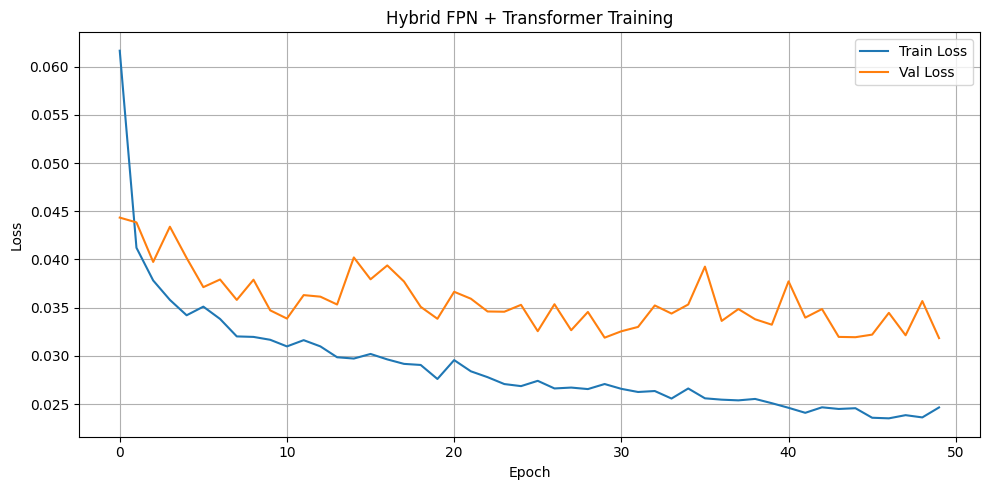

In [2]:
# --- Train ---
def train_model(model, train_loader, val_loader, device, epochs=50):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_losses.append(running_train_loss / len(train_loader))

        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()
        val_losses.append(running_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Hybrid FPN + Transformer Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model

# --- Run Everything ---
if __name__ == "__main__":
    set_seed(42)
    root_dir = "/home/adityab/ADRL/final/Data"  # Replace with your path
    dataset = CrackDataset(root_dir, transform=PairedTransform())

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=2, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FPNMultiScaleTransformerSeg(backbone_name="resnet50")  # or "resnet18", etc.
    trained_model = train_model(model, train_loader, val_loader, device, epochs=50)

Precision: 0.8268077496032151
Recall: 0.7364072737718839
F1 Score: 0.7789935891278473
Mean Dice Score: 0.7727181803993232
Mean IoU Score: 0.6445593532265687


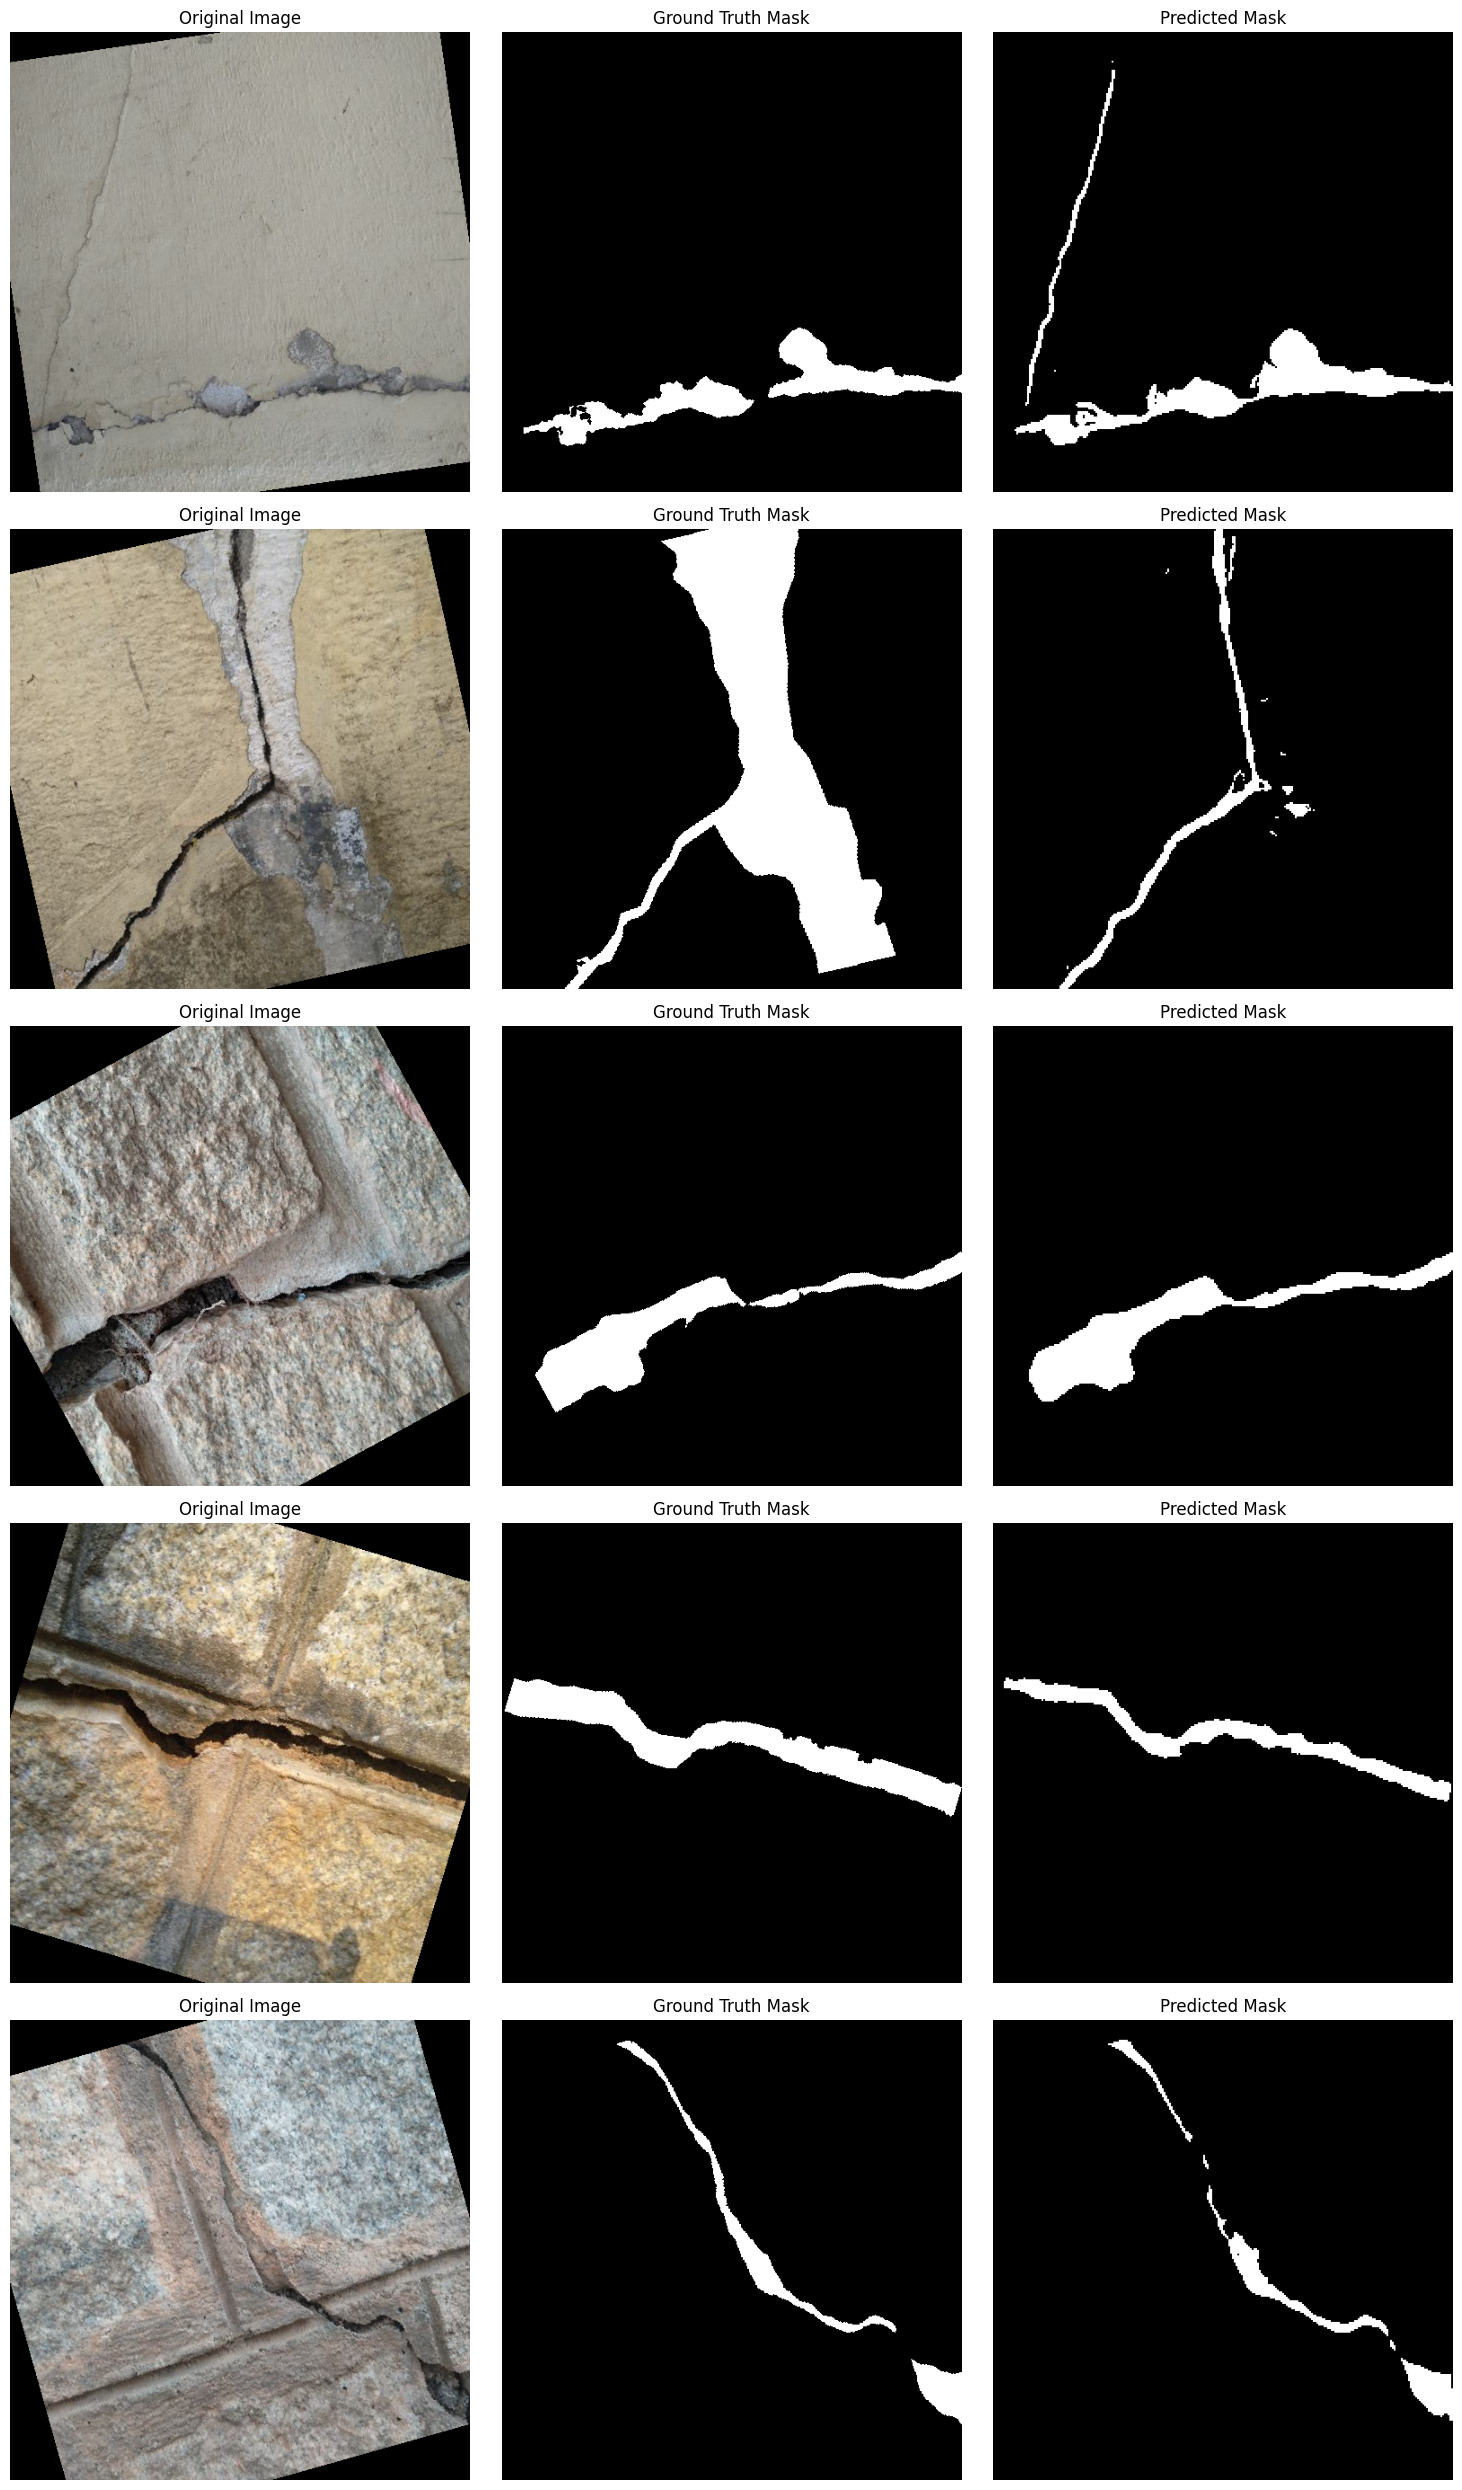

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import random

# Helper metric functions
def dice_coefficient(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# Thresholding function
def binarize(tensor, threshold=0.5):
    return (tensor > threshold).float()

# Evaluate the model on test set
def evaluate_model(model, test_loader, device='cuda', threshold=0.5, num_images_to_display=5):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []
    dice_scores = []
    iou_scores = []

    display_samples = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))
            preds = binarize(outputs, threshold)

            # Save for metrics
            all_preds.extend(preds.cpu().numpy().astype(np.uint8).flatten())
            all_targets.extend(masks.cpu().numpy().astype(np.uint8).flatten())

            dice_scores.append(dice_coefficient(preds, masks).item())
            iou_scores.append(iou_score(preds, masks).item())

            if len(display_samples) < num_images_to_display:
                display_samples.append((images.cpu(), masks.cpu(), preds.cpu()))

    # Classification metrics
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Mean Dice Score:", mean_dice)
    print("Mean IoU Score:", mean_iou)

    # Visualize 5 test samples
    fig, axs = plt.subplots(num_images_to_display, 3, figsize=(15, 5 * num_images_to_display))
    if num_images_to_display == 1:
        axs = [axs]

    for idx, (image, mask, pred) in enumerate(display_samples):
        img = np.transpose(image[0].numpy(), (1, 2, 0))
        axs[idx][0].imshow(img)
        axs[idx][0].set_title("Original Image")
        axs[idx][0].axis("off")

        axs[idx][1].imshow(mask[0][0].numpy(), cmap='gray')
        axs[idx][1].set_title("Ground Truth Mask")
        axs[idx][1].axis("off")

        axs[idx][2].imshow(pred[0][0].numpy(), cmap='gray')
        axs[idx][2].set_title("Predicted Mask")
        axs[idx][2].axis("off")

    plt.tight_layout()
    plt.show()

test_loader = DataLoader(test_ds, batch_size=2, shuffle=False)
# Run evaluation
evaluate_model(model=trained_model, test_loader=test_loader, device=device, threshold=0.5, num_images_to_display=5)

In [3]:

from sklearn.metrics import precision_score, recall_score, f1_score
import torchvision.transforms.functional as TF

def evaluate_metrics(model, dataloader, device, threshold=0.5, num_vis=5):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    fig, axes = plt.subplots(num_vis, 3, figsize=(10, 3 * num_vis))

    with torch.no_grad():
        count = 0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

            all_preds.append(preds.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

            # --- Visualization ---
            if count < num_vis:
                for i in range(min(num_vis - count, images.size(0))):
                    img = TF.to_pil_image(images[i].cpu())
                    gt_mask = masks[i][0].cpu().numpy()
                    pred_mask = preds[i][0].cpu().numpy()

                    axes[count, 0].imshow(img)
                    axes[count, 0].set_title("Input")
                    axes[count, 1].imshow(gt_mask, cmap='gray')
                    axes[count, 1].set_title("Ground Truth")
                    axes[count, 2].imshow(pred_mask, cmap='gray')
                    axes[count, 2].set_title("Prediction")
                    for ax in axes[count]: ax.axis('off')
                    count += 1

    plt.tight_layout()
    plt.show()

    # --- Metrics ---
    y_true = np.concatenate(all_targets).flatten()
    y_pred = np.concatenate(all_preds).flatten()

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    dice = (2 * intersection) / (y_true.sum() + y_pred.sum())
    iou = intersection / union

    print(f"\n--- Evaluation Metrics ---")
    print(f"Precision:     {precision:.4f}")
    print(f"Recall:        {recall:.4f}")
    print(f"F1 Score:      {f1:.4f}")
    print(f"Mean Dice:     {dice:.4f}")
    print(f"Mean IoU:      {iou:.4f}")


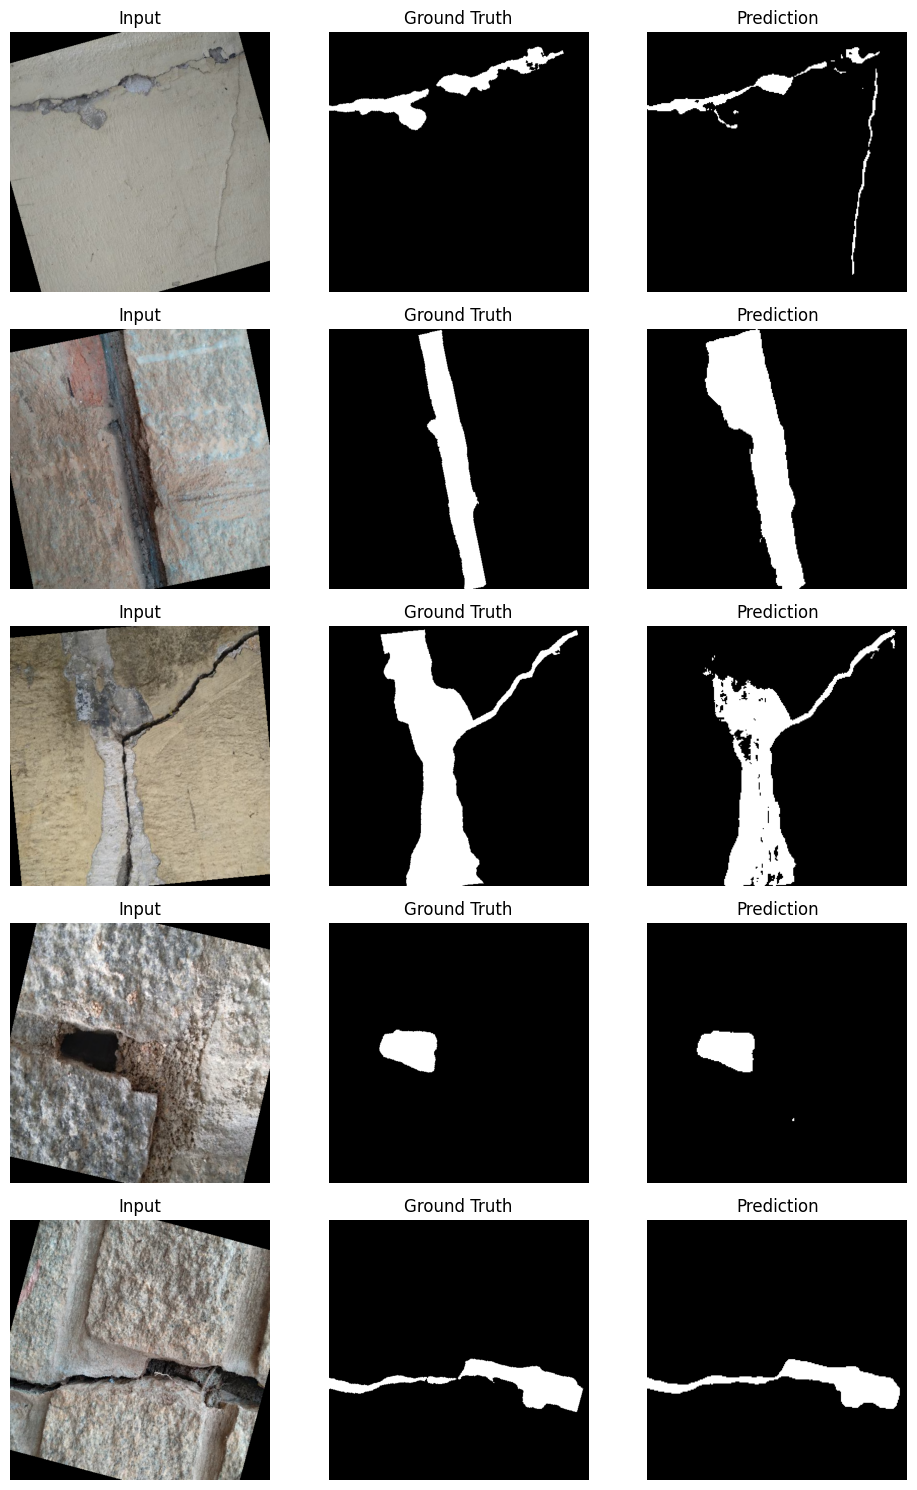


--- Evaluation Metrics ---
Precision:     0.8279
Recall:        0.7695
F1 Score:      0.7976
Mean Dice:     0.7976
Mean IoU:      0.6634


In [4]:
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False)
evaluate_metrics(trained_model, test_loader, device)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os, json, random, cv2
import matplotlib.pyplot as plt


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For CUDA deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# Dataset & Transform
class PairedTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
        ])

    def __call__(self, image, mask):
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        image = self.transforms(image)

        random.seed(seed)
        torch.manual_seed(seed)
        mask = self.transforms(mask)
        return image, mask

def json_to_mask(mask_json, image_size):
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)
    for shape in mask_json['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
    return mask

class CrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') and os.path.exists(os.path.join(root_dir, f.replace('.jpg', '.json')))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        json_path = img_path.replace('.jpg', '.json')

        image = Image.open(img_path).convert("RGB")
        with open(json_path, 'r') as f:
            mask_json = json.load(f)
        mask = json_to_mask(mask_json, image.size)
        mask = Image.fromarray(mask)

        if self.transform:
            image, mask = self.transform(image, mask)

        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

In [2]:
# --- Gated Attention Block ---
class GatedAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(2*channels, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, lateral, topdown):
        # Both: [B, C, H, W]
        concat = torch.cat([lateral, topdown], dim=1)  # [B, 2C, H, W]
        gate = self.sigmoid(self.conv(concat))         # [B, C, H, W] in [0,1]
        fused = gate * lateral + (1 - gate) * topdown
        return fused

# --- FPN Encoder (ResNet18/34) ---
class FPNEncoder(nn.Module):
    def __init__(self, backbone="resnet50", pretrained=True):
        super().__init__()
        net = getattr(models, backbone)(pretrained=pretrained)
        self.enc0 = nn.Sequential(net.conv1, net.bn1, net.relu)  # /2, 64
        self.enc1 = nn.Sequential(net.maxpool, net.layer1)       # /4, 64
        self.enc2 = net.layer2                                   # /8, 128
        self.enc3 = net.layer3                                   # /16, 256
        self.enc4 = net.layer4                                   # /32, 512

    def forward(self, x):
        x0 = self.enc0(x)   # 64, /2
        x1 = self.enc1(x0)  # 64, /4
        x2 = self.enc2(x1)  # 128, /8
        x3 = self.enc3(x2)  # 256, /16
        x4 = self.enc4(x3)  # 512, /32
        return [x0, x1, x2, x3, x4]

# --- FPN + Gated Attention Decoder ---
class GatedFPNDecoder(nn.Module):
    def __init__(self, channels=[64, 64, 128, 256, 512]):
        super().__init__()
        # lateral 1x1 to match top-down channels
        self.lat4 = nn.Conv2d(channels[4], channels[3], 1)
        self.lat3 = nn.Conv2d(channels[3], channels[2], 1)
        self.lat2 = nn.Conv2d(channels[2], channels[1], 1)
        self.lat1 = nn.Conv2d(channels[1], channels[0], 1)
        # gated attention for each fusion
        self.gate3 = GatedAttentionBlock(channels[3])
        self.gate2 = GatedAttentionBlock(channels[2])
        self.gate1 = GatedAttentionBlock(channels[1])
        self.gate0 = GatedAttentionBlock(channels[0])
        # smooth convs
        self.smooth3 = nn.Conv2d(channels[3], channels[3], 3, padding=1)
        self.smooth2 = nn.Conv2d(channels[2], channels[2], 3, padding=1)
        self.smooth1 = nn.Conv2d(channels[1], channels[1], 3, padding=1)
        self.smooth0 = nn.Conv2d(channels[0], channels[0], 3, padding=1)

    def forward(self, feats):
        x0, x1, x2, x3, x4 = feats  # lowest to deepest
        # Top-down: Start from x4 (deepest)
        td3 = F.interpolate(self.lat4(x4), size=x3.shape[2:], mode="nearest")
        f3 = self.gate3(lateral=x3, topdown=td3)
        f3 = self.smooth3(f3)

        td2 = F.interpolate(self.lat3(f3), size=x2.shape[2:], mode="nearest")
        f2 = self.gate2(lateral=x2, topdown=td2)
        f2 = self.smooth2(f2)

        td1 = F.interpolate(self.lat2(f2), size=x1.shape[2:], mode="nearest")
        f1 = self.gate1(lateral=x1, topdown=td1)
        f1 = self.smooth1(f1)

        td0 = F.interpolate(self.lat1(f1), size=x0.shape[2:], mode="nearest")
        f0 = self.gate0(lateral=x0, topdown=td0)
        f0 = self.smooth0(f0)

        out = F.interpolate(f0, scale_factor=2, mode="bilinear", align_corners=False)  # Final up to full size
        return out

# --- Final Segmentation Model ---
class GatedFPN(nn.Module):
    def __init__(self, backbone="resnet50"):
        super().__init__()
        self.encoder = FPNEncoder(backbone)
        # Set channel sizes depending on backbone
        if backbone in ["resnet18", "resnet34"]:
            channels = [64, 64, 128, 256, 512]
        elif backbone in ["resnet50", "resnet101", "resnet152"]:
            channels = [64, 256, 512, 1024, 2048]
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        self.decoder = GatedFPNDecoder(channels)
        self.out_conv = nn.Conv2d(channels[0], 1, 1)

    def forward(self, x):
        feats = self.encoder(x)
        x = self.decoder(feats)
        x = self.out_conv(x)
        return x

/home/adityab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adityab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 0.0595, Val Loss: 0.0486
Epoch 2/50, Train Loss: 0.0396, Val Loss: 0.0437
Epoch 3/50, Train Loss: 0.0354, Val Loss: 0.0403
Epoch 4/50, Train Loss: 0.0327, Val Loss: 0.0415
Epoch 5/50, Train Loss: 0.0324, Val Loss: 0.0361
Epoch 6/50, Train Loss: 0.0310, Val Loss: 0.0343
Epoch 7/50, Train Loss: 0.0310, Val Loss: 0.0360
Epoch 8/50, Train Loss: 0.0290, Val Loss: 0.0343
Epoch 9/50, Train Loss: 0.0295, Val Loss: 0.0350
Epoch 10/50, Train Loss: 0.0281, Val Loss: 0.0366
Epoch 11/50, Train Loss: 0.0279, Val Loss: 0.0350
Epoch 12/50, Train Loss: 0.0277, Val Loss: 0.0347
Epoch 13/50, Train Loss: 0.0266, Val Loss: 0.0345
Epoch 14/50, Train Loss: 0.0260, Val Loss: 0.0384
Epoch 15/50, Train Loss: 0.0256, Val Loss: 0.0329
Epoch 16/50, Train Loss: 0.0261, Val Loss: 0.0343
Epoch 17/50, Train Loss: 0.0258, Val Loss: 0.0344
Epoch 18/50, Train Loss: 0.0249, Val Loss: 0.0358
Epoch 19/50, Train Loss: 0.0246, Val Loss: 0.0322
Epoch 20/50, Train Loss: 0.0242, Val Loss: 0.0345
Epoch 21/

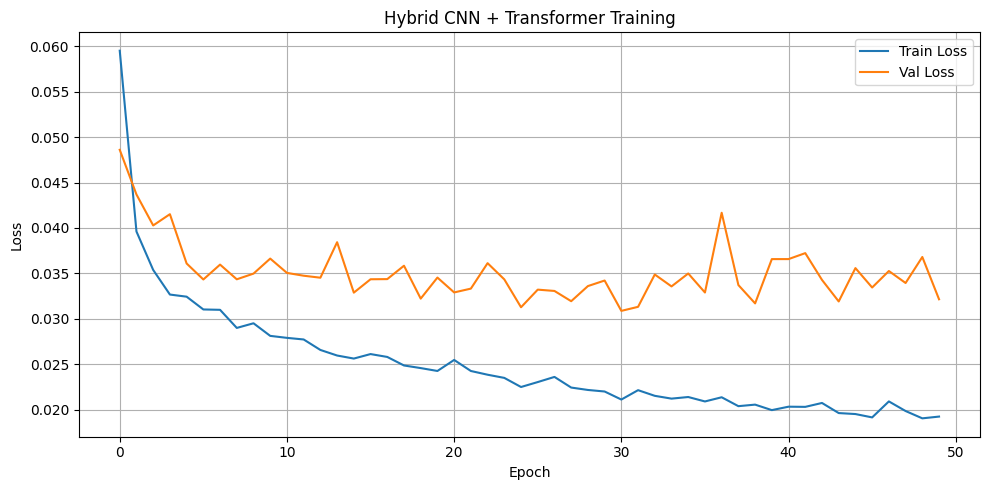

In [3]:
# --- Train ---
def train_model(model, train_loader, val_loader, device, epochs=50):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_losses.append(running_train_loss / len(train_loader))

        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()
        val_losses.append(running_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Hybrid CNN + Transformer Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model 

# --- Usage Example ---
if __name__ == "__main__":
    set_seed(42)
    root_dir = "/home/adityab/ADRL/final/Data"  # Replace with your path
    dataset = CrackDataset(root_dir, transform=PairedTransform())

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=2, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = GatedFPN("resnet50")
    trained_model = train_model(model, train_loader, val_loader, device, epochs=50)

Precision: 0.834046380515467
Recall: 0.7823189686613761
F1 Score: 0.8073549764635868
Mean Dice Score: 0.8011741855210959
Mean IoU Score: 0.6834623206679414


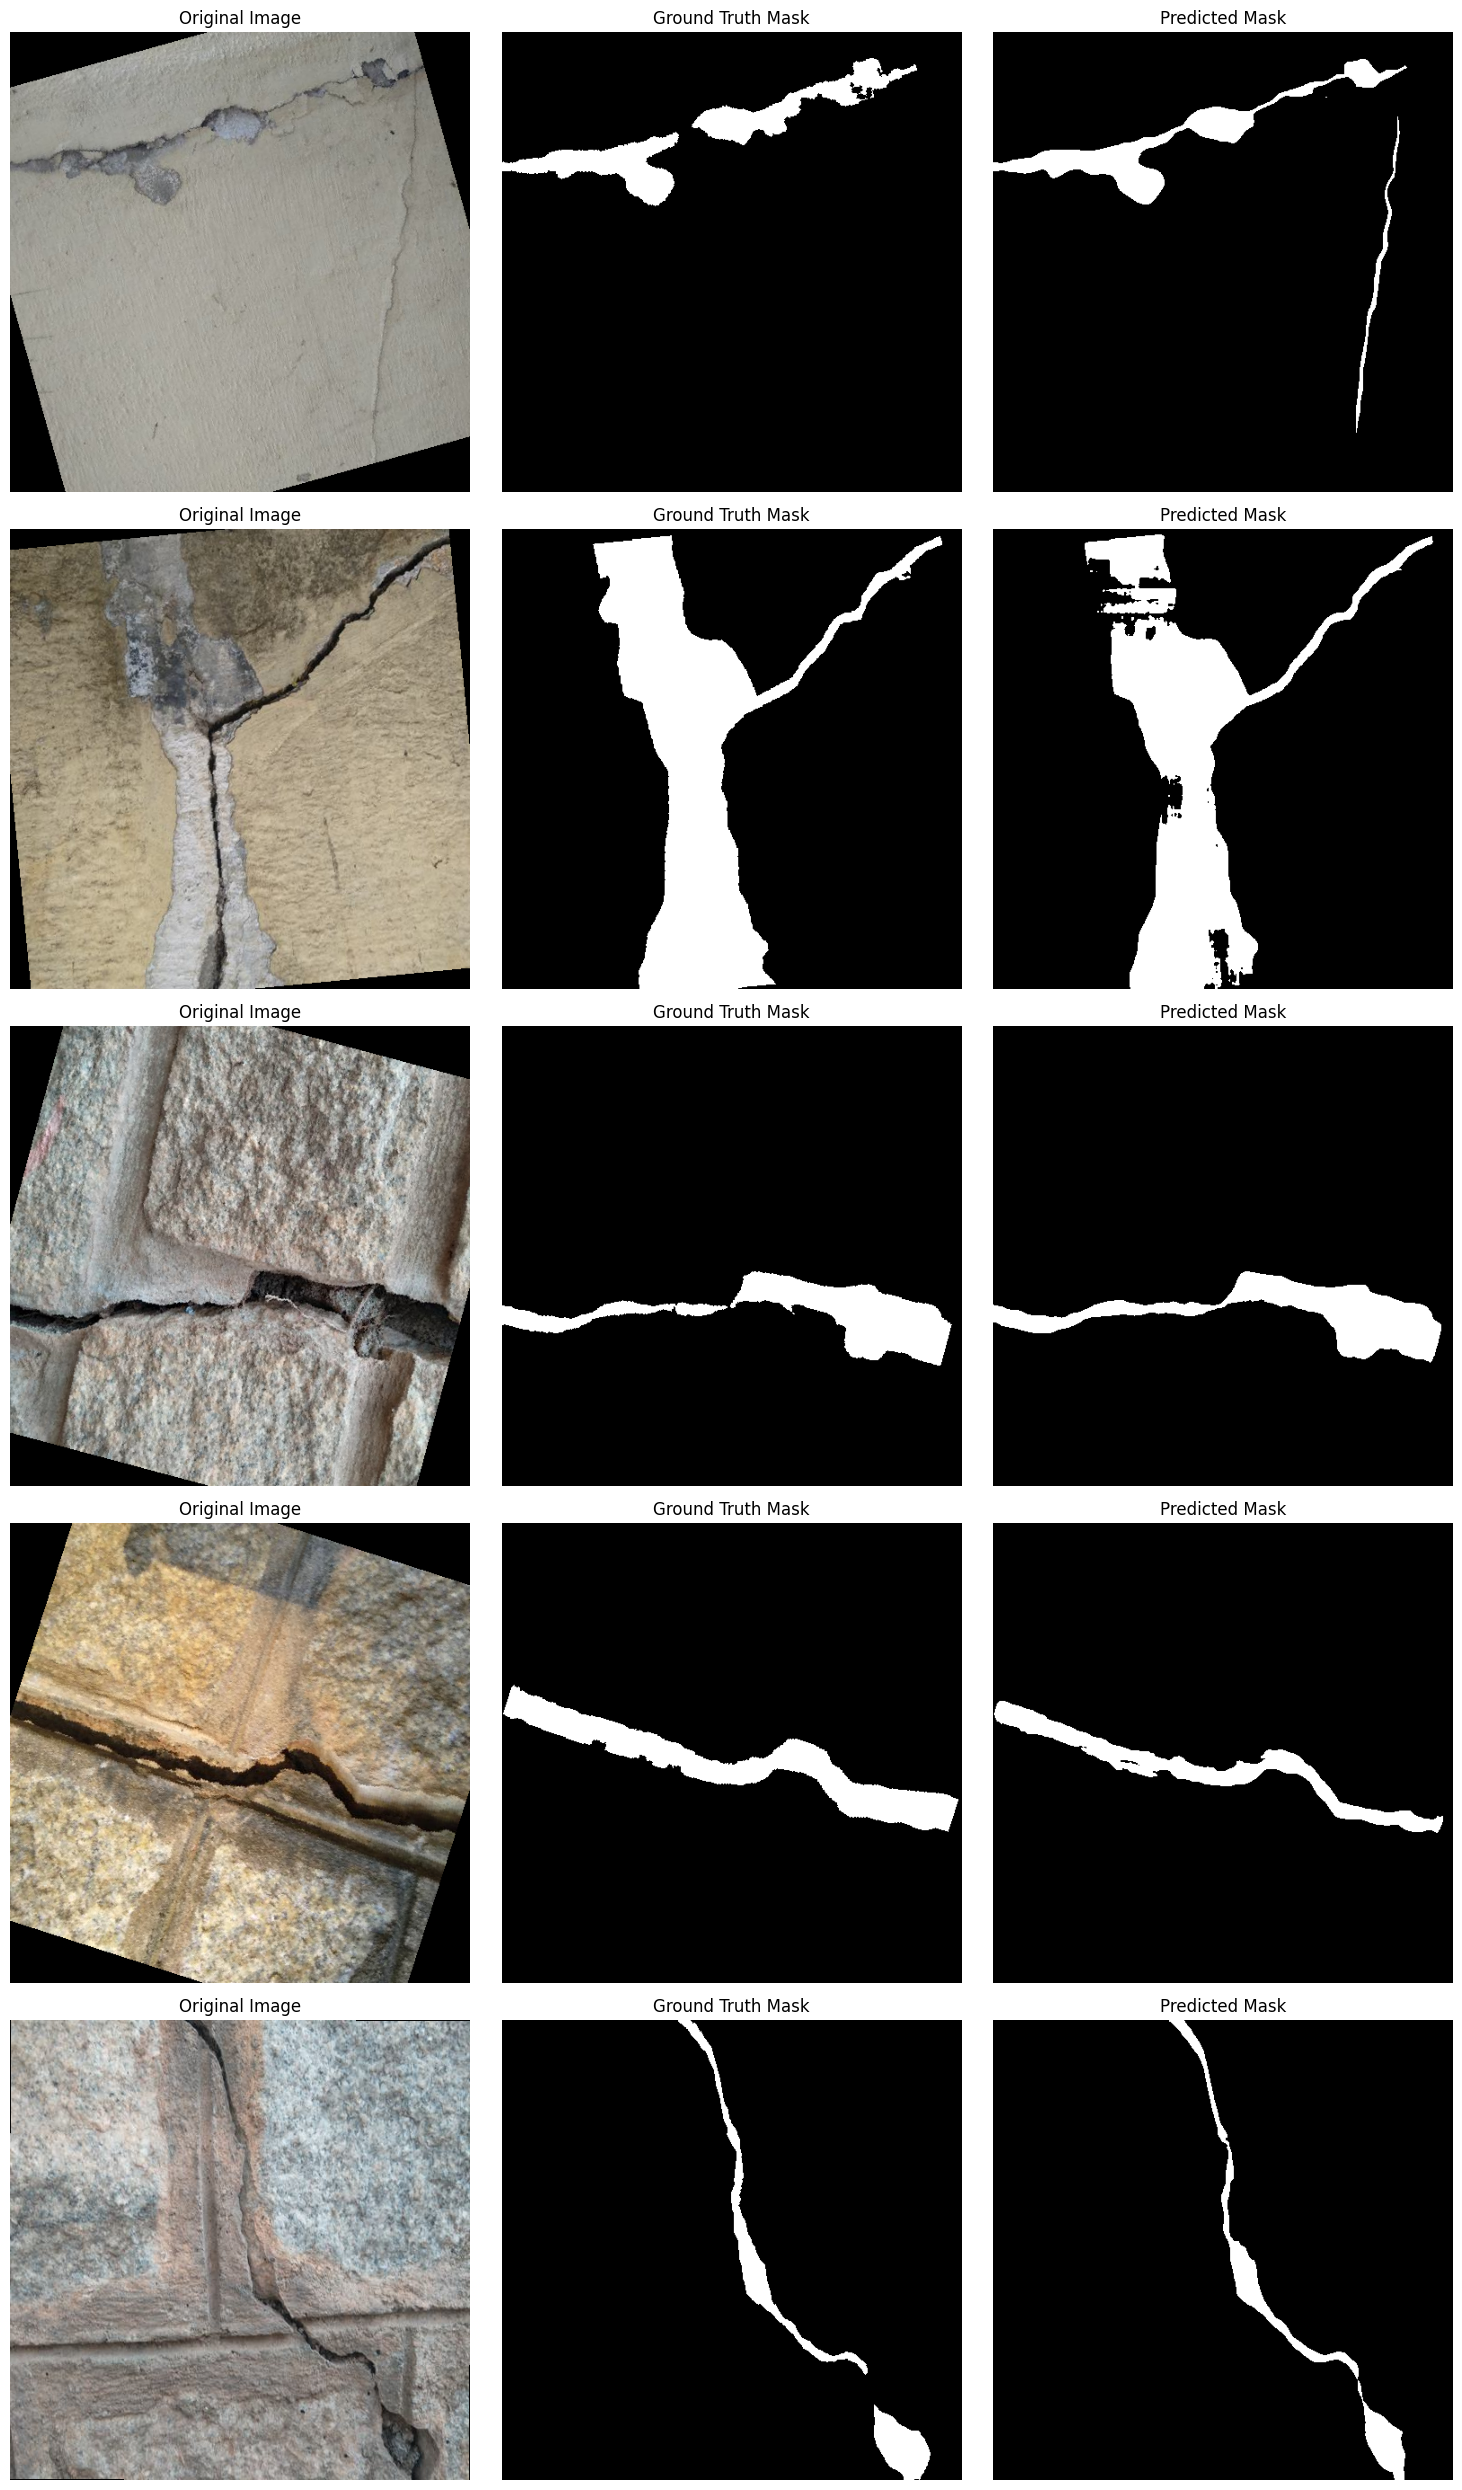

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import random

# Helper metric functions
def dice_coefficient(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# Thresholding function
def binarize(tensor, threshold=0.5):
    return (tensor > threshold).float()

# Evaluate the model on test set
def evaluate_model(model, test_loader, device='cuda', threshold=0.5, num_images_to_display=5):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []
    dice_scores = []
    iou_scores = []

    display_samples = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))
            preds = binarize(outputs, threshold)

            # Save for metrics
            all_preds.extend(preds.cpu().numpy().astype(np.uint8).flatten())
            all_targets.extend(masks.cpu().numpy().astype(np.uint8).flatten())

            dice_scores.append(dice_coefficient(preds, masks).item())
            iou_scores.append(iou_score(preds, masks).item())

            if len(display_samples) < num_images_to_display:
                display_samples.append((images.cpu(), masks.cpu(), preds.cpu()))

    # Classification metrics
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Mean Dice Score:", mean_dice)
    print("Mean IoU Score:", mean_iou)

    # Visualize 5 test samples
    fig, axs = plt.subplots(num_images_to_display, 3, figsize=(15, 5 * num_images_to_display))
    if num_images_to_display == 1:
        axs = [axs]

    for idx, (image, mask, pred) in enumerate(display_samples):
        img = np.transpose(image[0].numpy(), (1, 2, 0))
        axs[idx][0].imshow(img)
        axs[idx][0].set_title("Original Image")
        axs[idx][0].axis("off")

        axs[idx][1].imshow(mask[0][0].numpy(), cmap='gray')
        axs[idx][1].set_title("Ground Truth Mask")
        axs[idx][1].axis("off")

        axs[idx][2].imshow(pred[0][0].numpy(), cmap='gray')
        axs[idx][2].set_title("Predicted Mask")
        axs[idx][2].axis("off")

    plt.tight_layout()
    plt.show()

test_loader = DataLoader(test_ds, batch_size=2, shuffle=False)
# Run evaluation
evaluate_model(model=trained_model, test_loader=test_loader, device=device, threshold=0.5, num_images_to_display=5)
